In [103]:
import sys
import warnings
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))
warnings.filterwarnings("ignore")

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from finetune.segment.chesapeake_datamodule import ChesapeakeDataModule
from finetune.segment.chesapeake_model import ChesapeakeSegmentor
from matplotlib.colors import ListedColormap

### Define paths and parameters

In [105]:
CHESAPEAKE_CHECKPOINT_PATH = (
    "../../../checkpoints/segment/last.ckpt"
)
CLAY_CHECKPOINT_PATH = "../../../checkpoints/clay-v1.5.ckpt"
METADATA_PATH = "../../../configs/metadata.yaml"

TRAIN_CHIP_DIR = "../../../../dataset/ready/train/chips/"
TRAIN_LABEL_DIR = "../../../../dataset/ready/train/labels/"
VAL_CHIP_DIR = "../../../../dataset/ready/val/chips/"
VAL_LABEL_DIR = "../../../../dataset/ready/val/labels/"

BATCH_SIZE = 32
NUM_WORKERS = 1
PLATFORM = "sentinel-2-l2a-4band"
NUM_CLASSES = 2

In [106]:
chip = np.load(os.path.join(TRAIN_CHIP_DIR, os.listdir(TRAIN_CHIP_DIR)[0]))
print("Chip shape:", chip.shape)

Chip shape: (4, 224, 224)


### Model Loading

In [ ]:
def get_model(chesapeake_checkpoint_path, clay_checkpoint_path, metadata_path, platform=None):
    model = ChesapeakeSegmentor.load_from_checkpoint(
        checkpoint_path=chesapeake_checkpoint_path,
        ckpt_path=clay_checkpoint_path,
    )
    # Set metadata and platform if not already set from checkpoint
    if platform is not None and (model.metadata is None or model.platform != platform):
        from box import Box
        import yaml
        with open(metadata_path, 'r') as f:
            model.metadata = Box(yaml.safe_load(f))
        model.platform = platform
    model.eval()
    return model

### Data Preparation

In [108]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    num_classes=None,
):
    dm = ChesapeakeDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        num_classes=num_classes,
    )
    dm.setup(stage="fit")
    val_dl = iter(dm.val_dataloader())
    batch = next(val_dl)
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [109]:
def run_prediction(model, batch):
    with torch.no_grad():
        outputs = model(batch)
    outputs = F.interpolate(
        outputs, size=(256, 256), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [123]:
def denormalize_images(normalized_images, means, stds):
    means = np.array(means).reshape(1, -1, 1, 1)
    stds = np.array(stds).reshape(1, -1, 1, 1)
    denormalized_images = normalized_images * stds + means
    denormalized_images = np.clip(denormalized_images, 0, 5000)
    denormalized_images = (denormalized_images / 5000.0 * 255).astype(np.uint8)
    return denormalized_images.astype(np.uint8)  # Do for NAIP/LINZ


def post_process(batch, outputs, metadata):
    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy()
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    means = list(metadata[PLATFORM].bands.mean.values())
    stds = list(metadata[PLATFORM].bands.std.values())
    norm_pixels = denormalize_images(pixels, means, stds)

    images = rearrange(norm_pixels[:, :3, :, :], "b c h w -> b h w c")

    return images, labels, preds

### Plotting

In [124]:
def plot_predictions(images, labels, preds):
    colors = [
        (0 / 255, 0 / 255, 255 / 255, 1),  # Deep Blue for water
        (34 / 255, 139 / 255, 34 / 255, 1),  # Forest Green for tree canopy / forest
        (154 / 255, 205 / 255, 50 / 255, 1),  # Yellow Green for low vegetation / field
        (210 / 255, 180 / 255, 140 / 255, 1),  # Tan for barren land
        (169 / 255, 169 / 255, 169 / 255, 1),  # Dark Gray for impervious (other)
        (105 / 255, 105 / 255, 105 / 255, 1),  # Dim Gray for impervious (road)
        (255 / 255, 255 / 255, 255 / 255, 1),  # White for no data
    ]
    cmap = ListedColormap(colors)

    fig, axes = plt.subplots(12, 8, figsize=(12, 18))

    # Plot the images
    plot_data(axes, images, row_offset=0, title="Image")

    # Plot the actual segmentation maps
    plot_data(axes, labels, row_offset=1, title="Actual", cmap=cmap, vmin=0, vmax=6)

    # Plot the predicted segmentation maps
    plot_data(axes, preds, row_offset=2, title="Pred", cmap=cmap, vmin=0, vmax=6)

    plt.tight_layout()
    plt.show()


def plot_data(ax, data, row_offset, title=None, cmap=None, vmin=None, vmax=None):
    for i, item in enumerate(data):
        row = row_offset + (i // 8) * 3
        col = i % 8
        ax[row, col].imshow(item, cmap=cmap, vmin=vmin, vmax=vmax)
        ax[row, col].axis("off")
        if title and col == 0:
            ax[row, col].set_title(title, rotation=0, fontsize=12)

In [ ]:
# Load model
model = get_model(CHESAPEAKE_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH, platform=PLATFORM)

In [113]:
# Get data
batch, metadata = get_data(
    TRAIN_CHIP_DIR,
    TRAIN_LABEL_DIR,
    VAL_CHIP_DIR,
    VAL_LABEL_DIR,
    METADATA_PATH,
    BATCH_SIZE,
    NUM_WORKERS,
    PLATFORM,
    NUM_CLASSES,
)
# Move batch to GPU
batch = {k: v.to("cuda") for k, v in batch.items()}

In [114]:
# Run prediction
outputs = run_prediction(model, batch)

In [125]:
# Post-process the results
images, labels, preds = post_process(batch, outputs, metadata)

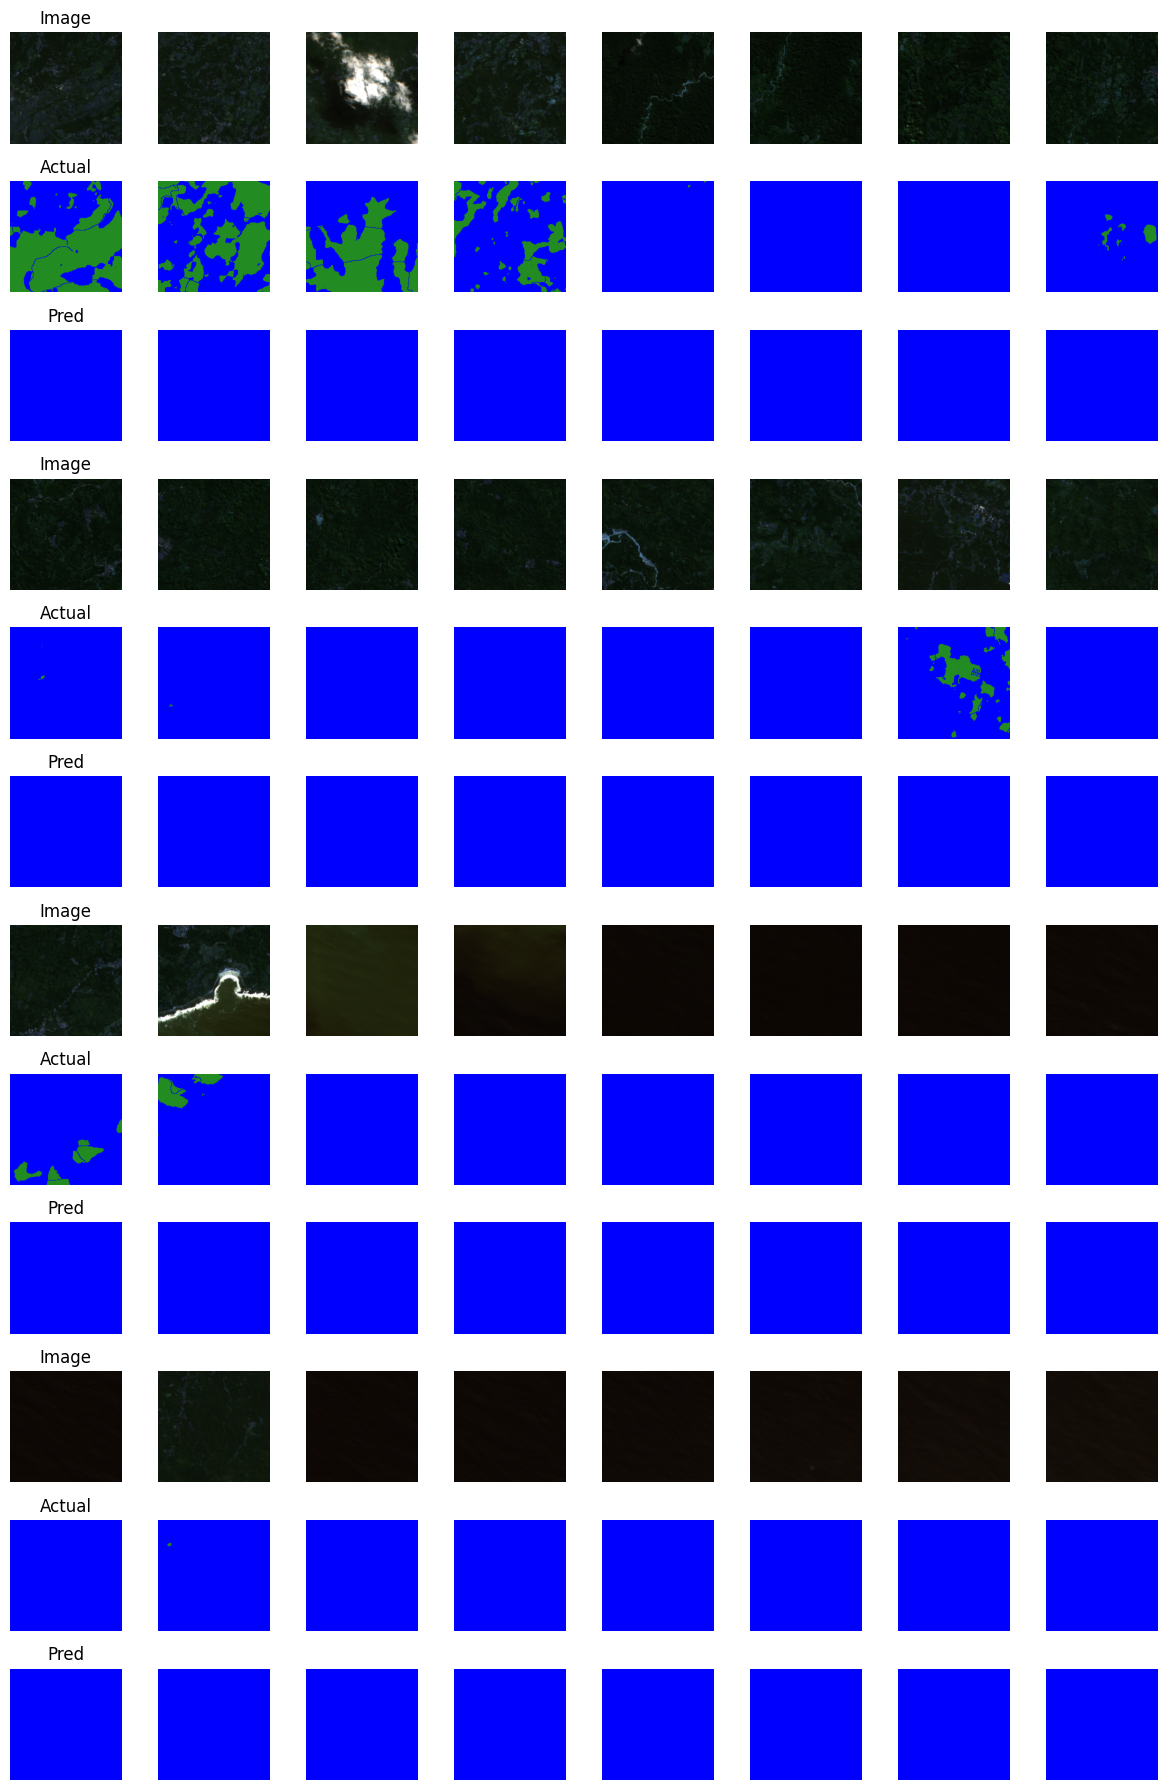

In [126]:
# Plot the predictions
plot_predictions(images, labels, preds)

In [117]:
# After Cell 17 (after run_prediction)
# CRITICAL: Inspect the actual model outputs
print("=" * 60)
print("DEBUGGING MODEL OUTPUTS")
print("=" * 60)

print(f"Outputs shape: {outputs.shape}")  # Should be [B, num_classes, H, W]
print(f"Expected: [batch_size, {NUM_CLASSES}, 256, 256]")

# Check logits for each class
for i in range(outputs.shape[1]):  # For each class
    class_logits = outputs[0, i, :, :]  # First sample, class i
    print(f"\nClass {i} logits:")
    print(f"  Min: {class_logits.min().item():.4f}")
    print(f"  Max: {class_logits.max().item():.4f}")
    print(f"  Mean: {class_logits.mean().item():.4f}")
    print(f"  Std: {class_logits.std().item():.4f}")

# Check if all classes have identical values
class_0 = outputs[0, 0, :10, :10]  # First 10x10 pixels
class_1 = outputs[0, 1, :10, :10]
print(f"\nAre class 0 and class 1 identical? {(class_0 == class_1).all().item()}")

# Check what argmax is actually selecting
preds_sample = torch.argmax(outputs[0:1], dim=1)[0]
unique_preds, counts = torch.unique(preds_sample, return_counts=True)
print(f"\nUnique predicted classes: {unique_preds.tolist()}")
print(f"Class counts: {counts.tolist()}")
print(f"Percentage class 0: {counts[0].item() / preds_sample.numel() * 100:.2f}%")

DEBUGGING MODEL OUTPUTS
Outputs shape: torch.Size([32, 2, 256, 256])
Expected: [batch_size, 2, 256, 256]

Class 0 logits:
  Min: 2.1570
  Max: 82.6204
  Mean: 19.4147
  Std: 8.0523

Class 1 logits:
  Min: -97.4293
  Max: -2.0047
  Mean: -25.5411
  Std: 15.3895

Are class 0 and class 1 identical? False

Unique predicted classes: [0]
Class counts: [65536]
Percentage class 0: 100.00%


In [127]:
# After Cell 16 or in a new cell
# Check label distribution in your dataset

import numpy as np
from pathlib import Path

label_dir = Path(VAL_LABEL_DIR)
label_files = list(label_dir.glob("*.npy"))[:500]  # Check first 500 labels

class_counts = {0: 0, 1: 0}
total_pixels = 0
all_zeros = 0  # Count chips that are entirely class 0
has_class_1 = 0  # Count chips that have any class 1

for label_file in label_files:
    label = np.load(label_file)
    unique, counts = np.unique(label, return_counts=True)
    total_pixels += label.size
    
    # Check if chip is entirely class 0
    if len(unique) == 1 and unique[0] == 0:
        all_zeros += 1
    elif 1 in unique:
        has_class_1 += 1
    
    for cls, count in zip(unique, counts):
        if cls in class_counts:
            class_counts[int(cls)] += count

print("=" * 60)
print("LABEL CLASS DISTRIBUTION ANALYSIS")
print("=" * 60)
print(f"Total chips analyzed: {len(label_files)}")
print(f"Chips entirely class 0: {all_zeros} ({all_zeros/len(label_files)*100:.1f}%)")
print(f"Chips with class 1: {has_class_1} ({has_class_1/len(label_files)*100:.1f}%)")
print()

for cls, count in class_counts.items():
    percentage = (count / total_pixels) * 100
    print(f"Class {cls}: {count:,} pixels ({percentage:.2f}% of all pixels)")

print()
print("=" * 60)
print("IMPLICATION:")
if all_zeros / len(label_files) > 0.7:
    print("⚠️  WARNING: >70% of chips are entirely class 0!")
    print("   The model can achieve high IoU by always predicting class 0.")
elif class_counts[0] / total_pixels > 0.9:
    print("⚠️  WARNING: >90% of pixels are class 0!")
    print("   Severe class imbalance - model defaults to class 0.")
else:
    print("Class distribution seems more balanced.")

LABEL CLASS DISTRIBUTION ANALYSIS
Total chips analyzed: 500
Chips entirely class 0: 227 (45.4%)
Chips with class 1: 273 (54.6%)

Class 0: 23,009,002 pixels (91.71% of all pixels)
Class 1: 2,078,998 pixels (8.29% of all pixels)

IMPLICATION:
⚠️  WARNING: >90% of pixels are class 0!
   Severe class imbalance - model defaults to class 0.
